# Google Earth Engine Panel Data Creation

## Initialize

In [1]:
# !pip install geemap
#!pip install ee

In [2]:
# !pip install uszipcode

In [1]:
#GEE specific
import ee
import geemap
import math

#plotting and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from time import time


In [2]:
#Initialize Google Earth Engine
#ee.Authenticate() #just needed the 1st time
ee.Initialize()

In [3]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

## Load Feature Collection - Shapefiles

In [4]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [5]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7fcf0a9856a0>,
 <ee.featurecollection.FeatureCollection at 0x7fcf0a985190>)

In [6]:
#Income Data
la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")

## Load NAIP Imagery

In [7]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [8]:
def get_images(param_dict):
    source_image_collection = params['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

    
    

In [9]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

{'2010_la_county': <ee.image.Image at 0x7fcf0aaed340>,
 '2010_sc_county': <ee.image.Image at 0x7fcf0aaed520>,
 '2012_la_county': <ee.image.Image at 0x7fcf0aaed700>,
 '2012_sc_county': <ee.image.Image at 0x7fcf0aaed8e0>,
 '2014_la_county': <ee.image.Image at 0x7fcf0aaedac0>,
 '2014_sc_county': <ee.image.Image at 0x7fcf0aaedca0>,
 '2016_la_county': <ee.image.Image at 0x7fcf0aaede80>,
 '2016_sc_county': <ee.image.Image at 0x7fcf0aaf10a0>,
 '2018_la_county': <ee.image.Image at 0x7fcf0aaf1280>,
 '2018_sc_county': <ee.image.Image at 0x7fcf0aaf1460>,
 '2020_la_county': <ee.image.Image at 0x7fcf0aaf1640>,
 '2020_sc_county': <ee.image.Image at 0x7fcf0aaf1820>}

In [10]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [11]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [12]:
#test to see if NDVI plot looks correct (define a different location in santa clara county just for visibility)
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [13]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Labeled Data

In [14]:
## Loading feature collections from Google Earth Engine

#water = ee.FeatureCollection("projects/california-lawn-detection/assets/water_torrance")
water_training = ee.FeatureCollection("projects/california-lawn-detection/assets/water_training")
trees_training = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_training")
grass_training = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_training")
turf_training = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_training")
#pv_training = ee.FeatureCollection("projects/california-lawn-detection/assets/pv_training")
impervious_training = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_training").limit(50)
soil_training = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_training").limit(50)

LABELED_SET = water_training.merge(trees_training).merge(grass_training).merge(turf_training).merge(impervious_training).merge(soil_training)



In [15]:
water_test = ee.FeatureCollection("projects/california-lawn-detection/assets/water_test")
vegetation_trees_test = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_test")
vegetation_grass_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_test")
turf_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_test")
#pv_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/pv_test")
impervious_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_test")
soil_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_test")

TEST_SET = water_test.merge(vegetation_trees_test).merge(vegetation_grass_test).merge(turf_test).merge(impervious_test).merge(soil_test)



## Build Training Set

In [16]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_la_county']

In [17]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 
         'G', 
         'B', 
         'N', 
         'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy', 
         'N_Contrast', 
         'N_Gearys']

train_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

test_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': TEST_SET,
  'properties': [LABEL],
  'scale': 1
})

In [18]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [19]:
print("Training Set Size in Pixels", train_data.aggregate_count('R').getInfo())

Training Set Size in Pixels 169069


In [20]:
print("Test Set Size in Pixels", test_data.aggregate_count('R').getInfo())

Test Set Size in Pixels 97964


## Machine Learning Model

In [21]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 200, minLeafPopulation = 5, bagFraction= 0.7)\
                   .train(train_data, LABEL, BANDS)
clf

In [22]:
training_image_classified = TRAINING_IMAGE.select(BANDS)\
                                          .classify(clf)


In [23]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [24]:
training_image_classified.bandNames().getInfo()

['classification']

In [25]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Evaluation Metrics

### Train Accuracy

In [39]:
train_accuracy = train_data.classify(clf).errorMatrix('landcover', 'classification')
train_conf_matrix = train_accuracy.getInfo()

In [40]:
print(f'Spot check to confirm pixel numbers: {np.array(train_conf_matrix).sum()}')
train_conf_matrix

Spot check to confirm pixel numbers: 169069


[[1331, 1, 0, 1, 1, 0],
 [0, 9475, 40, 8, 12, 11],
 [0, 93, 6591, 2, 0, 38],
 [0, 15, 1, 2398, 5, 0],
 [0, 3, 0, 4, 21239, 60],
 [0, 12, 1, 2, 37, 127688]]

### Test Accuracy

In [41]:
test_accuracy = test_data.classify(clf).errorMatrix('landcover', 'classification')
test_conf_matrix = test_accuracy.getInfo()

In [42]:
print(f'Spot check to confirm pixel numbers: {np.array(test_conf_matrix).sum()}')
test_conf_matrix

Spot check to confirm pixel numbers: 97964


[[275, 0, 0, 0, 0, 0],
 [0, 2620, 141, 16, 12, 12],
 [0, 164, 1327, 3, 0, 38],
 [0, 29, 0, 602, 222, 7],
 [9, 3, 4, 847, 70443, 1647],
 [0, 36, 151, 23, 387, 18946]]

## Binary Classification and Area Calculation

In [26]:
def area_calculation(image, class_number, shape, pixel_scale = 20):

    if type(shape) == str:
        shape = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', shape))

    areaImage = image.eq(class_number).multiply(ee.Image.pixelArea())

    area = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = shape,
        scale = pixel_scale,
        maxPixels = 1e13)


    area_sq_m = area.getInfo().get('classification')

    area_sq_km = area_sq_m / 1e6

    return area_sq_km

In [27]:
def ndvi_calculation(image, class_number, shape, ref_image, pixel_scale=1):
    
    if type(shape) == str:
        shape = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', shape))
        
    ndvi = ref_image.normalizedDifference(['N', 'R'])
    image_clipped = image.clip(shape)
    
    NDVI_for_class = ndvi.updateMask(image_clipped.select('classification').eq(class_number))
    
    reducer = ee.Reducer.mean()\
                        .combine(ee.Reducer.max(),sharedInputs=True)\
                        .combine(ee.Reducer.min(),sharedInputs=True)
    
    
    qty = NDVI_for_class.reduceRegion(
        reducer = reducer, 
        geometry = shape, 
        scale = pixel_scale, 
        maxPixels = 1e13)
    return qty



### Create Panel Data

In [28]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))

In [46]:
year_list = [2010,2012, 2014, 2016, 2018,2020]
zipcode_list = ['90802','90732','90744']

In [41]:
polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', '90027'))

In [42]:
polygon

In [43]:
Map.addLayer(polygon, {'color': 'blue'}, 'Long Beach')

In [44]:
Map

Map(bottom=837318.0, center=[34.10356083744765, -118.29657554626466], controls=(WidgetControl(options=['positi…

In [47]:
test_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : year_list,
        'counties': {'lacounty': la_county}
         }

inference_images = get_images(test_image_params)
inference_images

{'2010_lacounty': <ee.image.Image at 0x7fe12a01c910>,
 '2012_lacounty': <ee.image.Image at 0x7fe12a01caf0>,
 '2014_lacounty': <ee.image.Image at 0x7fe12a01ccd0>,
 '2016_lacounty': <ee.image.Image at 0x7fe12a01ceb0>,
 '2018_lacounty': <ee.image.Image at 0x7fe12a0200d0>,
 '2020_lacounty': <ee.image.Image at 0x7fe12a0202b0>}

In [49]:
keys = {'year','polygon','water_area','vegetation_trees_area', 
        'vegetation_grass_area', 'turf_area', 'impervious_area',
        'soil_area', 'total_area','tree_ndvi_mean', 'tree_ndvi_max','tree_ndvi_min',
       'grass_ndvi_mean', 'grass_ndvi_max','grass_ndvi_min'}


dictionary = {}
for i in keys:
    dictionary[i] = []

for i in zipcode_list:
    for j in list(inference_images.items()):
        im = j[1]
        imagery = im.select(BANDS).classify(clf)
        name = j[0]
        
        start = time()
        polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', i))

        dictionary['year'].append(j[0][:4]) 
        dictionary['polygon'].append(i)

        water_area = area_calculation(imagery, 0, polygon, 20)
        dictionary['water_area'].append(water_area)

        vegetation_trees_area = area_calculation(imagery, 1, polygon, 20)
        dictionary['vegetation_trees_area'].append(vegetation_trees_area)

        vegetation_grass_area = area_calculation(imagery, 2, polygon, 20)
        dictionary['vegetation_grass_area'].append(vegetation_grass_area)

        turf_area = area_calculation(imagery, 3, polygon, 20)
        dictionary['turf_area'].append(turf_area)

        impervious_area = area_calculation(imagery, 4, polygon, 20)
        dictionary['impervious_area'].append(impervious_area)

        soil_area = area_calculation(imagery, 5, polygon, 20)
        dictionary['soil_area'].append(soil_area)

        total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area
        dictionary['total_area'].append(total_area)
        
        tree_ndvi_mean, tree_ndvi_max, tree_ndvi_min = ndvi_calculation(imagery, 1, polygon, ref_image = im).getInfo().values()
        dictionary['tree_ndvi_mean'].append(tree_ndvi_mean)
        dictionary['tree_ndvi_max'].append(tree_ndvi_max)
        dictionary['tree_ndvi_min'].append(tree_ndvi_min)
        
        grass_ndvi_mean, grass_ndvi_max, grass_ndvi_min = ndvi_calculation(imagery, 2, polygon, ref_image = im).getInfo().values()
        dictionary['grass_ndvi_mean'].append(grass_ndvi_mean)
        dictionary['grass_ndvi_max'].append(grass_ndvi_max)
        dictionary['grass_ndvi_min'].append(grass_ndvi_min)
        
        
        
        end = time()
        print(f'Zip Code: {i}, Year: {j[0][:4]} ::: completed in {end-start} seconds.')
              
              
              

Zip Code: 90802, Year: 2010 ::: completed in 5.352809429168701 seconds.
Zip Code: 90802, Year: 2012 ::: completed in 5.81826639175415 seconds.
Zip Code: 90802, Year: 2014 ::: completed in 5.416517972946167 seconds.
Zip Code: 90802, Year: 2016 ::: completed in 4.904638767242432 seconds.
Zip Code: 90802, Year: 2018 ::: completed in 5.346947908401489 seconds.
Zip Code: 90802, Year: 2020 ::: completed in 5.36874532699585 seconds.
Zip Code: 90732, Year: 2010 ::: completed in 5.265907287597656 seconds.
Zip Code: 90732, Year: 2012 ::: completed in 5.497626543045044 seconds.
Zip Code: 90732, Year: 2014 ::: completed in 5.05759596824646 seconds.
Zip Code: 90732, Year: 2016 ::: completed in 5.36907958984375 seconds.
Zip Code: 90732, Year: 2018 ::: completed in 5.363760232925415 seconds.
Zip Code: 90732, Year: 2020 ::: completed in 4.880769729614258 seconds.
Zip Code: 90744, Year: 2010 ::: completed in 4.902722358703613 seconds.
Zip Code: 90744, Year: 2012 ::: completed in 5.080910921096802 secon

In [50]:
#extract just necessary columns from dictionary dataframe
df = pd.DataFrame(dictionary) #[['polygon','soil_area','vegetation_grass_area','water_area','vegetation_trees_area','impervious_area','turf_area']]
df

,water_area,grass_ndvi_mean,polygon,vegetation_trees_area,year,grass_ndvi_max,impervious_area,tree_ndvi_min,tree_ndvi_mean,tree_ndvi_max,soil_area,turf_area,total_area,grass_ndvi_min,vegetation_grass_area
0,0.020307,0.564246,90802,0.567951,2010,0.201082,3.961103,-1.000000,0.580645,0.197091,9.946693,0.020524,14.756617,0.066667,0.240040
1,4.336096,0.935897,90802,0.036484,2012,0.369144,10.240158,-0.909091,0.896552,0.356585,0.000000,0.022223,14.756617,0.071942,0.121657
2,0.592164,0.810811,90802,0.117972,2014,0.337255,13.647141,-1.000000,0.753846,0.266801,0.055013,0.132617,14.756617,-0.002625,0.211711
3,0.000000,0.538126,90802,0.150912,2016,0.278476,11.192958,-0.007194,0.547619,0.267496,1.871144,1.293212,14.756617,-0.003559,0.248391
4,0.400216,0.707547,90802,0.147730,2018,0.364322,13.764950,-0.615385,0.711628,0.316654,0.062795,0.226933,14.756617,0.048458,0.153992
5,0.000000,0.677130,90802,0.303413,2020,0.320822,9.826548,-0.293103,0.681818,0.311851,3.206738,1.127961,14.756617,-0.018750,0.291956
6,0.000000,1.000000,90732,0.342060,2010,0.236906,3.723097,-0.300000,1.000000,0.348123,3.333733,0.049900,8.231549,0.067961,0.782760
7,1.001474,0.940299,90732,0.314949,2012,0.403049,5.615781,-1.000000,0.920000,0.382882,0.218328,0.338561,8.231549,0.075988,0.742456
8,0.090093,0.871795,90732,0.854109,2014,0.369956,4.893265,-1.000000,0.844444,0.383804,1.085189,0.222701,8.231549,-0.009404,1.086193
9,0.010787,0.882353,90732,0.490740,2016,0.351630,3.813398,-0.483146,0.885417,0.304986,2.880041,0.538597,8.231549,-0.020649,0.497986


### Plot Area Results

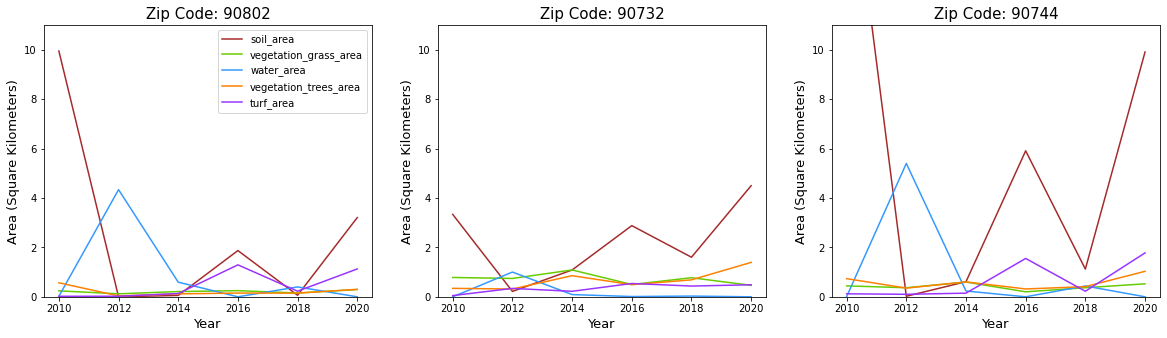

In [51]:
years= [2010, 2012, 2014, 2016, 2018, 2020]
zips = df.polygon.unique()
fig, ax = plt.subplots(1,3, figsize = (20,5))

labels = [ 'soil_area',
 'vegetation_grass_area',
 'water_area',
 'vegetation_trees_area',
 'turf_area']

colors = ['brown','#66CC00','#3399FF','#FF8000','#9933FF']


for i in range(3):
    for j in range(len(labels)):
        if j == 'polygon':
            continue
        else:
            d = df[df.polygon == zips[i]]
            ax[i].plot(years, d[labels[j]], color = colors[j], label = labels[j])
    ax[i].set_title(f'Zip Code: {zips[i]}', size = 15)
    ax[i].set_xlabel('Year', size = 13)
    ax[i].set_ylabel('Area (Square Kilometers)', size = 13)
    ax[i].set_ylim(0,11)
    ax[0].legend()
    
# plt.savefig(fname = 'test.png', dpi = 200)